<a href="https://colab.research.google.com/github/abdulsamadkhan/Llama2_Chat/blob/main/RAFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Creating RAFT dataset using LLM 3.5
##1.Introduction
This tutorial is about creating a dataset using Retrieval Augmented Fine Tuning (RAFT).This is a new way of finetuning the domain specific model by creating a real like RAG situation, where $k$ documents (contexts) are retrived and only one document contains the answe to the query. In RAFT, given a question (query), and a set of retrieved documents, it trains the model to ignore those documents that don't help answer the question, these documents are called, distractor documents, this is illustrated in the figure below. RAFT uses a chain-of-thought to improve the model's ability to reason. unlike according to the paper, RAFT consistently improves the model's performance across PubMed, HotpotQA, and Gorilla datasets, presenting a post-training recipe to improve pre-trained LLMs to in-domain RAG.

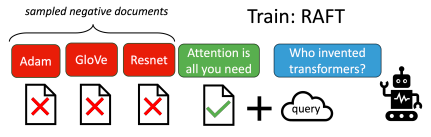




Before creating the dataset using RAFT, I want to highlight the differentce of this techinque with existing  methods in adapting LLM to a specific domain, using the analogy between training an LLM in the real-world setting of preparing for an exam.

###Closed-Book Exam:
 A closed book exam often refers to a scenario where the LLMs do not have access to any additional documents or references to answer the questions during the exam. This is equivelant to fine-tune a general LLM for our domain knowleddge,  as shown in the figure.
 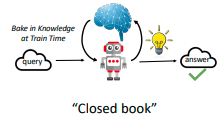

###Open Book Exam:
It is refered to the scenario in which the LLM uses  external sources of information (e.g., a website or
a book chapter). In such scenario, typically, the LLM is
paired with a retriever which retrieves $k$ documents (or
specific segments of the document) which are appended to
the prompt. It is only through these documents retrieved that
the LLM gains access to “new knowledge”, so its performance  largely dependent on
the quality of the retriever and how accurately the retriever
can identify the most relevant piece of information. as shown in the figure

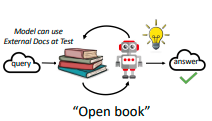

###Domain Specific Open-Book Exam (RAFT):
In this scnariot he LLM can respond to the prompt
using use any and all information from this specific domain,
which it has been fine-tuned on. This is illustrated in the figure

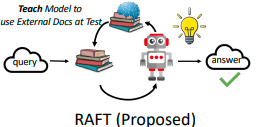



##2. RAFT-DATASET
Let us create our own raft-datset using `gpt-turbo3.5`.


###2.1 Installing Libraries

In [ ]:
#required libraries
!pip install llama-index
!pip install llama-index-packs-raft-dataset


In [ ]:
# importing the class for generating the RAFTDataset
from llama_index.packs.raft_dataset import RAFTDatasetPack

In [ ]:
#loading openAI API Key
import openai
from google.colab import userdata
openai.api_key = userdata.get('OPENAI_KEY')


###2.2 Download Data
For this tutorial, I made a text file about Wasim Akram, the well-known Pakistani cricketer. I gathered the info from Wikipedia

In [ ]:
# this data will be stored in output directory ./WasimAkram.txt
!wget  "https://raw.githubusercontent.com/abdulsamadkhan/Llama2_Chat/main/Data/WasimAkram.txt" -O './WasimAkram.txt'



###2.3 creating `gpt 3.5 turbo` object
Since I want to use `gpt 3.5 turbu` so I am creating my  own llm object. If we do not create and pass this object to `RAFTDatssetPack` object, default llm `gpt4` will be created.

In [ ]:
#create llm object
from llama_index.llms.openai import OpenAI
llm = OpenAI(temperature=0, n=1, model="gpt-3.5-turbo")

### 2.4 instantiating RAFTDatasetPack object
Following are the arguments to the RAFTDatasetPack object, which helps in creating a customized generation process.

Arguments:
*   `file_path` - the path at which the document is located
* `llm` - llm object, we can use any llm here, I have used gpt3.5 turbo, if no llm is used it will pick GPT4 by default. GPT4 is expenvie
* `embed-model` you can provide any embedding model, if you do not then gpt embedding model is picked
* `num_questions_per_chunk` the number of data points to generate per chunk

* `number_distract_docs` - the number of distractor documents to include per data point
* `chunk_size` - the size of each chunk in number of tokens:


In [ ]:
raft_dataset = RAFTDatasetPack(file_path="./WasimAkram.txt",llm=llm,
                                 num_questions_per_chunk=2,
                                 num_distract_docs=3,
                                 )

###2.5 Exploring raft_dataset
####Chunks details
After creating the raft_dataset object I explored the RAFTDatasetPack object. The RAFTDatasetPack uses `SemanticSplitterNodeParser(...)`
which splits documents into semantically similar chunks. In our case it creates 9 chunks.

Note: Due to this splitter, i realized that `chunk_size` parameter has no effect on different values passed.



In [ ]:
chunks = raft_dataset.get_chunks("./WasimAkram.txt", raft_dataset.chunk_size)
len(chunks)

####Important observations
while creating dataset I observed  the following important points

* Each chunk is passed to LLM to create questions using a well crafted prompt, this is done through this function `generate_instructions_gen(chunk,#numberofQuestions )`

*  `oracle_context` is the true chunk from which the questions and answers both are derived. This is termed as `D*` in the paper

* `cot_answer` is generated based on prompt using the `oracle_context` and `question`. this is termed as `A*` in the paper. This is based on `Chain of Thought` idea.
The prompt for generating `cot_answer` using given question and chunk is given below
          prompt = f"""
            Question: {question}\nContext: {chunk}\n
            Answer this question using the information given in the context above. Here is things to pay attention to:
            - First provide step-by-step reasoning on how to answer the question.
            - In the reasoning, if you need to copy paste some sentences from the context, include them in ##begin_quote## and ##end_quote##. This would mean that things outside of ##begin_quote## and ##end_quote## are not directly copy paste from the context.
            - End your response with final answer in the form <ANSWER>: $answer, the answer should be succinct.
        """   

In [ ]:
dataset = raft_dataset.run()

* For each chunk, uses `gpt3.5-turbo` to synthetically generate dataset.


In [ ]:
#printing the dataset
dataset

Dataset({
    features: ['id', 'type', 'question', 'context', 'oracle_context', 'cot_answer', 'instruction'],
    num_rows: 20
})

### 2.6 mapping to Notation:
 * `question` is mapped to `Q ` in the paper
 * `context` is mapped set of documents `D_k ` in the paper
 * `oracle_context` is mapped to `D* ` in the paper
 * `cot_answer` is mapped to `A* ` in the paper.

In [ ]:
#oracle document is relevant, distractor document is irrelevant
#exploring the first data point
len(dataset[0]['context']['sentences'][0])

3

###2.7 saving the raft_dataset

In [ ]:
output_path = "./RAFTDATA"
# Save as .arrow format
dataset.save_to_disk(output_path)

# Save as .jsonl format
dataset.to_json(output_path + ".jsonl")

Saving the dataset (0/1 shards):   0%|          | 0/20 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

279797

#Refrences

* https://arxiv.org/pdf/2403.10131.pdf
* https://github.com/run-llama/llama_index/blob/main/llama-index-packs/llama-index-packs-raft-dataset/examples/raft_dataset.ipynb
* https://github.com/ShishirPatil/gorilla/tree/main/raft
